## 基础包与数据导入

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('..\\source\\house_prices.csv')
i=15
df.info()#显示列名和数据类型类型
df.head(6)#显示前n行，n默认为5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6028 entries, 0 to 6027
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   house_id      6028 non-null   int64 
 1   neighborhood  6028 non-null   object
 2   area          6028 non-null   int64 
 3   bedrooms      6028 non-null   int64 
 4   bathrooms     6028 non-null   int64 
 5   style         6028 non-null   object
 6   price         6028 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 329.8+ KB


,house_id,neighborhood,area,bedrooms,bathrooms,style,price
0,1112,B,1188,3,2,ranch,598291
1,491,B,3512,5,3,victorian,1744259
2,5952,B,1134,3,2,ranch,571669
3,3525,A,1940,4,2,ranch,493675
4,5108,B,2208,6,4,victorian,1101539
5,7507,C,1785,4,2,lodge,455235


## 变量探索
数据质量和整洁度都还不错，毕竟是经过基础评估与清洗的数据

In [3]:
# 异常值处理
# ================ 异常值检验函数：iqr & z分数 两种方法 =========================
def outlier_test(data, column, method=None, z=2):
    """ 以某列为依据，使用 上下截断点法 检测异常值(索引) """
    """ 
    full_data: 完整数据
    column: full_data 中的指定行，格式 'x' 带引号
    return 可选; outlier: 异常值数据框 
    upper: 上截断点;  lower: 下截断点
    method：检验异常值的方法（可选, 默认的 None 为上下截断点法），
            选 Z 方法时，Z 默认为 2
    """
    # ================== 上下截断点法检验异常值 ==============================
    if method == None:
        print(f'以 {column} 列为依据，使用 上下截断点法(iqr) 检测异常值...')
        print('=' * 70)
        # 四分位点；这里调用函数会存在异常
        column_iqr = np.quantile(data[column], 0.75) - np.quantile(data[column], 0.25)
        # 1，3 分位数
        (q1, q3) = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
        # 计算上下截断点
        upper, lower = (q3 + 1.5 * column_iqr), (q1 - 1.5 * column_iqr)
        # 检测异常值
        outlier = data[(data[column] <= lower) | (data[column] >= upper)]
        print(f'第一分位数: {q1}, 第三分位数：{q3}, 四分位极差：{column_iqr}')
        print(f"上截断点：{upper}, 下截断点：{lower}")
        return outlier, upper, lower
    # ===================== Z 分数检验异常值 ==========================
    if method == 'z':
        """ 以某列为依据，传入数据与希望分段的 z 分数点，返回异常值索引与所在数据框 """
        """ 
        params
        data: 完整数据
        column: 指定的检测列
        z: Z分位数, 默认为2，根据 z分数-正态曲线表，可知取左右两端的 2%，
           根据您 z 分数的正负设置。也可以任意更改，知道任意顶端百分比的数据集合
        """
        print(f'以 {column} 列为依据，使用 Z 分数法，z 分位数取 {z} 来检测异常值...')
        print('=' * 70)
        # 计算两个 Z 分数的数值点
        mean, std = np.mean(data[column]), np.std(data[column])
        upper, lower = (mean + z * std), (mean - z * std)
        print(f"取 {z} 个 Z分数：大于 {upper} 或小于 {lower} 的即可被视为异常值。")
        print('=' * 70)
        # 检测异常值
        outlier = data[(data[column] <= lower) | (data[column] >= upper)]
        return outlier, upper, lower

In [4]:
outlier, upper, lower = outlier_test(data=df, column='price', method='z')
outlier.info(); outlier.sample(5)

以 price 列为依据，使用 Z 分数法，z 分位数取 2 来检测异常值...
取 2 个 Z分数：大于 1801467.1287622033 或小于 -293051.3610117055 的即可被视为异常值。
<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 22 to 6018
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   house_id      335 non-null    int64 
 1   neighborhood  335 non-null    object
 2   area          335 non-null    int64 
 3   bedrooms      335 non-null    int64 
 4   bathrooms     335 non-null    int64 
 5   style         335 non-null    object
 6   price         335 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 20.9+ KB


,house_id,neighborhood,area,bedrooms,bathrooms,style,price
2428,7425,B,3920,6,4,victorian,1945555
3814,3482,B,4525,6,4,victorian,2243820
4391,4733,B,3801,7,4,victorian,1886972
2460,2401,B,4113,6,4,victorian,2040704
2011,4382,B,4617,6,4,victorian,2289176


In [5]:
# 这里简单的丢弃即可
df.drop(index=outlier.index, inplace=True)

In [6]:
# 类别变量，又称为名义变量，nominal variables
nominal_vars = ['neighborhood', 'style']

for each in nominal_vars:
    print(each, ':')
    print(df[each].agg(['value_counts']).T)
    # 直接 .value_counts().T 无法实现下面的效果
     ## 必须得 agg，而且里面的中括号 [] 也不能少
    print('='*35)
    # 发现各类别的数量也都还可以，为下面的方差分析做准备

neighborhood :
                 B     A     C
value_counts  2093  1875  1725
style :
              victorian  ranch  lodge
value_counts       2674   1790   1229


In [7]:
# 热力图 
def heatmap(data, method='pearson', camp='RdYlGn', figsize=(10 ,8)):
    """
    data: 整份数据
    method：默认为 pearson 系数
    camp：默认为：RdYlGn-红黄蓝；YlGnBu-黄绿蓝；Blues/Greens 也是不错的选择
    figsize: 默认为 10，8
    """
    ## 消除斜对角颜色重复的色块
    #     mask = np.zeros_like(df2.corr())
    #     mask[np.tril_indices_from(mask)] = True
    plt.figure(figsize=figsize, dpi= 80)
    sns.heatmap(data.corr(method=method), \
                xticklabels=data.corr(method=method).columns, \
                yticklabels=data.corr(method=method).columns, cmap=camp, \
                center=0, annot=True)
    # 要想实现只是留下对角线一半的效果，括号内的参数可以加上 mask=mask

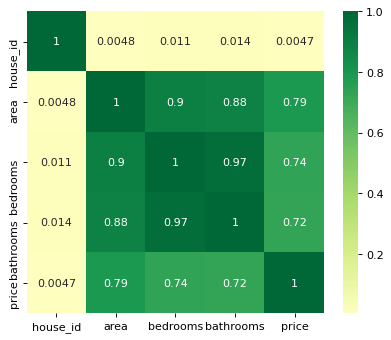

In [8]:
# 通过热力图可以看出 area，bedrooms，bathrooms 等变量与房屋价格 price 的关系都还比较强
 ## 所以值得放入模型，但分类变量 style 与 neighborhood 两者与 price 的关系未知
heatmap(data=df, figsize=(6,5))

In [9]:
# 刚才的探索我们发现，style 与 neighborhood 的类别都是三类，
 ## 如果只是两类的话我们可以进行卡方检验，所以这里我们使用方差分析
    
## 利用回归模型中的方差分析
## 只有 statsmodels 有方差分析库
## 从线性回归结果中提取方差分析结果
import statsmodels.api as sm
from statsmodels.formula.api import ols # ols 为建立线性回归模型的统计学库
from statsmodels.stats.anova import anova_lm

插播一条样本量和置信水平 α_level 的注意点（置信水平 α 的选择经验）

    样本量            α-level
    ≤ 100              10%
    100 ＜ n ≤ 500      5%
    500 ＜ n ≤ 1000     1%
    n ＞ 2000          千分之一
    
样本量过大，α-level 就没什么意义了。

数据量很大时，p 值就没用了，样本量通常不超过 5000，

为了证明两变量间的关系是稳定的，样本量要控制好。

In [10]:
# 数据集样本数量：6028，这里随机选择 600 条，如果希望分层抽样，可参考文章：
df = df.copy().sample(600)

# C 表示告诉 Python 这是分类变量，否则 Python 会当成连续变量使用
## 这里直接使用方差分析对所有分类变量进行检验
## 下面几行代码便是使用统计学库进行方差分析的标准姿势
lm = ols('price ~ C(neighborhood) + C(style)', data=df).fit()
anova_lm(lm)

# Residual 行表示模型不能解释的组内的，其他的是能解释的组间的
# df: 自由度（n-1）- 分类变量中的类别个数减1
# sum_sq: 总平方和（SSM），residual行的 sum_eq: SSE
# mean_sq: msm, residual行的 mean_sq: mse
# F：F 统计量，查看卡方分布表即可
# PR(>F): P 值

# 反复刷新几次，发现都很显著，所以这两个变量也挺值得放入模型中

,df,sum_sq,mean_sq,F,PR(>F)
C(neighborhood),2.0,1.695937e+13,8.479685e+12,124.060633,9.257830e-46
C(style),2.0,4.062505e+13,2.031253e+13,297.179095,3.260459e-90
Residual,595.0,4.066892e+13,6.835113e+10,NaN,NaN


## 多元线性回归建模

In [11]:
from statsmodels.formula.api import ols

lm = ols('price ~ area + bedrooms + bathrooms', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     360.7
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          1.68e-133
Time:                        09:18:24   Log-Likelihood:                -8287.3
No. Observations:                 600   AIC:                         1.658e+04
Df Residuals:                     596   BIC:                         1.660e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.113e+04   2.56e+04      2.774      0.006    2.08e+04    1.21e+05
area         234.2665     18.850     12.428      0.000     197.247     271.286
bedrooms    2.984e+04   2.55e+04      1.169      0.243   -2.03e+04       8e+04
bathrooms   8121.3185   3.68e+04      0.221      0.826   -6.42e+04    8.04e+04
==============================================================================
Omnibus:                      101.571   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.036
Skew:                           1.221   Prob(JB):                     5.87e-34
Kurtosis:                       3.395   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 模型优化
发现精度还不够高，这里通过添加虚拟变量与使用方差膨胀因子检测多元共线性的方式来提升模型精度

In [40]:
# 设置虚拟变量
# 以名义变量 neighborhood 街区为例
nominal_data = df['neighborhood']

# 设置虚拟变量
dummies = pd.get_dummies(nominal_data)
dummies.sample()  # pandas 会自动帮你命名

# 每个名义变量生成的虚拟变量中，需要各丢弃一个，这里以丢弃C为例
dummies.drop(columns=['C'], inplace=True)
dummies.sample()

,A,B
2946,0,1


In [41]:
# 将结果与原数据集拼接
results = pd.concat(objs=[df, dummies], axis='columns')  # 按照列来合并
results.sample(3)
# 对名义变量 style 的处理可自行尝试

,house_id,neighborhood,area,bedrooms,bathrooms,style,price,A,B
4884,4934,B,2699,5,3,victorian,1343450,0,1
2618,5623,A,1211,2,1,lodge,312647,1,0
4737,6644,A,903,3,2,ranch,236415,1,0


In [42]:
# 再次建模
lm = ols('price ~ area + bedrooms + bathrooms + A + B', data=results).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1324.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          2.70e-319
Time:                        18:08:09   Log-Likelihood:                -8018.1
No. Observations:                 600   AIC:                         1.605e+04
Df Residuals:                     594   BIC:                         1.607e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.391e+05   2.06e+04    -11.605      0.000    -2.8e+05   -1.99e+05
area         341.9557     12.229     27.962      0.000     317.938     365.974
bedrooms    1.122e+04   1.72e+04      0.651      0.515   -2.26e+04    4.51e+04
bathrooms    123.9497   2.41e+04      0.005      0.996   -4.72e+04    4.74e+04
A          -4820.3883   1.65e+04     -0.292      0.771   -3.73e+04    2.76e+04
B           5.342e+05   1.56e+04     34.183      0.000    5.04e+05    5.65e+05
==============================================================================
Omnibus:                       11.333   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.472
Skew:                           0.313   Prob(JB):                      0.00323
Kurtosis:                       3.259   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# 模型末尾提示可能存在多元共线性，需要处理一下

In [44]:
# 自定义方差膨胀因子的检测公式
def vif(df, col_i):
    """
    df: 整份数据
    col_i：被检测的列名
    """
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

In [45]:
test_data = results[['area', 'bedrooms', 'bathrooms', 'A', 'B']]
for i in test_data.columns:
    print(i, '\t', vif(df=test_data, col_i=i))
# 发现 bedrooms 和 bathrooms 存在强相关性，可能这两个变量是解释同一个问题

area 	 6.034883307660626
bedrooms 	 21.46374991672584
bathrooms 	 19.86799611963858
A 	 1.475079541377202
B 	 1.4764704795325205


In [46]:
# 果然，bedrooms 和 bathrooms 这两个变量的方差膨胀因子较高，
 # 也印证了方差膨胀因子大多成对出现的原则，这里我们丢弃膨胀因子较大的 bedrooms 即可
lm = ols(formula='price ~ area + bathrooms + A + B', data=results).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1657.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          7.71e-321
Time:                        18:08:13   Log-Likelihood:                -8018.3
No. Observations:                 600   AIC:                         1.605e+04
Df Residuals:                     595   BIC:                         1.607e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.318e+05   1.73e+04    -13.397      0.000   -2.66e+05   -1.98e+05
area         344.5051     11.579     29.751      0.000     321.764     367.247
bathrooms   1.349e+04   1.26e+04      1.072      0.284   -1.12e+04    3.82e+04
A          -4280.9275   1.65e+04     -0.260      0.795   -3.67e+04    2.81e+04
B           5.342e+05   1.56e+04     34.201      0.000    5.04e+05    5.65e+05
==============================================================================
Omnibus:                       10.225   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.277
Skew:                           0.296   Prob(JB):                      0.00587
Kurtosis:                       3.247   Cond. No.                     9.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# 再次进行多元共线性检测
test_data = df[['area', 'bathrooms']]
for i in test_data.columns:
    print(i, '\t', vif(df=test_data, col_i=i))

area 	 5.367014396715305
bathrooms 	 5.367014396715305


# 精度没变，但具体问题还是需要结合具体业务来分析